In [1]:
# Change this to whatever your directory you're working from is - this should be
# the head level with Code and Data directories.
main_path = '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import keras
import numpy as np
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
import copy
import random as python_random
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from google.colab import files
import sklearn.preprocessing
import scipy

import sys
import importlib

# set seeds
np.random.seed(768)
python_random.seed(869)
tf.random.set_seed(1234)

from google.colab import drive
drive.mount('/content/drive')

sys.path.append(main_path+"Code")
import vep
importlib.reload(vep)

Mounted at /content/drive


<module 'vep' from '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/Code/vep.py'>

In [3]:
# First, let's load our train and validate sets
data_dir = main_path+'Data/'
train_file = data_dir+'train_processed_clinvar_seqs_with_clusters_clustershuffle.csv'
val_file = data_dir+'validate_processed_clinvar_seqs_with_clusters_clustershuffle.csv'
test_file = data_dir+'test_processed_clinvar_seqs_with_clusters_clustershuffle.csv'

# Instantiate a Model1 class and use it to process my input and output
m1 = vep.Model1()
m1.process_input_output_training(train_file,val_file,test_file)

In [4]:
# Build our specified model
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(1,40)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Add in our code to save the 
#checkpoint = ModelCheckpoint("aa_subs_best_model_epoch{epoch:02d}.ckpt", monitor='val_accuracy', verbose=1,
#    save_best_only=True, mode='auto', save_freq='epoch')

nepochs = 30
history = model.fit(m1.X_train,
                    m1.Y_train,
                    epochs=nepochs,
                    batch_size=512,
                    validation_data=(m1.X_val, m1.Y_val)
)
                    #callbacks=[checkpoint])

m1.nn_model = model
m1.nn_history = history

Epoch 1/30
10/10 [==============================] - 1s 30ms/step - loss: 0.7651 - categorical_accuracy: 0.3853 - val_loss: 0.7491 - val_categorical_accuracy: 0.3207
Epoch 2/30
10/10 [==============================] - 0s 5ms/step - loss: 0.7262 - categorical_accuracy: 0.3919 - val_loss: 0.7199 - val_categorical_accuracy: 0.3510
Epoch 3/30
10/10 [==============================] - 0s 4ms/step - loss: 0.7064 - categorical_accuracy: 0.4265 - val_loss: 0.7013 - val_categorical_accuracy: 0.4293
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6932 - categorical_accuracy: 0.5294 - val_loss: 0.6883 - val_categorical_accuracy: 0.5581
Epoch 5/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6844 - categorical_accuracy: 0.6007 - val_loss: 0.6789 - val_categorical_accuracy: 0.6414
Epoch 6/30
10/10 [==============================] - 0s 4ms/step - loss: 0.6786 - categorical_accuracy: 0.6496 - val_loss: 0.6733 - val_categorical_accuracy: 0.6818
Epoch 7/30
10/1

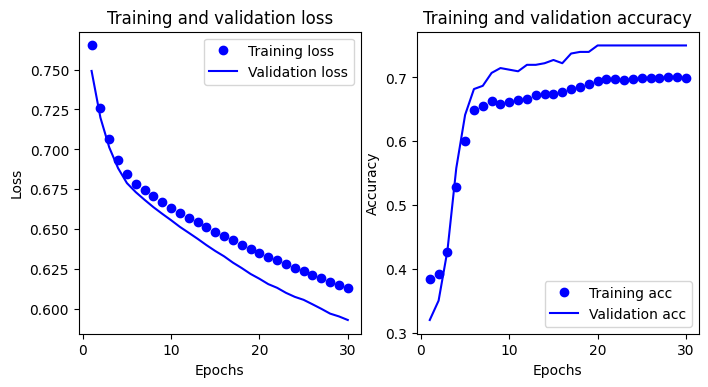

In [5]:
m1.plot_accuracy_and_loss()

Test accuracy is 0.7089783549308777


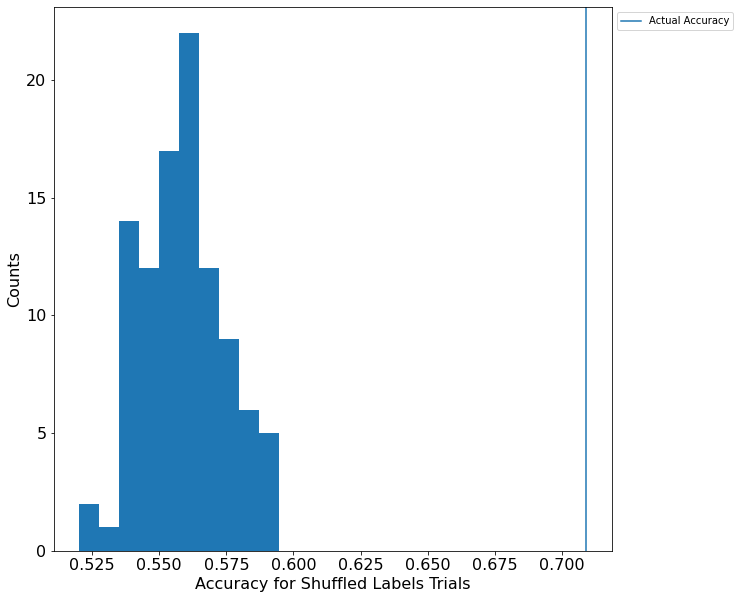

In [6]:
m1.plot_shuffled_accuracies(m1.X_test,m1.Y_test)

In [7]:
m1.nn_model.save(main_path+'Code/Trained_Model_Weights/Model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/Code/Trained_Model_Weights/Model1/assets


For curiosity's sake, let's compare our findings to the BLOSUM62 matrix (https://en.wikipedia.org/wiki/BLOSUM), which is essentially a matrix of transition probabilities for going from one amino acid to the other. This model was built using sequence alignments, and is currently the default setting for scoring sequences in the blastp program. (BLASTP is a bioinformatics go-to piece of software - it allows you to search for a protein sequence of interest against a database of sequences and return ones that score above a threshold. It's used for finding proteins that are similar (perhaps share homology) across multiple species, for one application. BLOSUM62, in this case, might represent a well-studied measure of how much penalty it might incur to substitute amino acids - which is somewhat analogous to our use case.

In [8]:
blosum = pd.read_csv(main_path+'Data/precursor_files/blosum62.csv')
blosum.head()

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
0,4,-1,-2,-2,0,-1,-1,0,-2,-1,-1,-1,-1,-2,-1,1,0,-3,-2,0
1,-1,5,0,-2,-3,1,0,-2,0,-3,-2,2,-1,-3,-2,-1,-1,-3,-2,-3
2,-2,0,6,1,-3,0,0,0,1,-3,-3,0,-2,-3,-2,1,0,-4,-2,-3
3,-2,-2,1,6,-3,0,2,-1,-1,-3,-4,-1,-3,-3,-1,0,-1,-4,-3,-3
4,0,-3,-3,-3,9,-3,-4,-3,-3,-1,-1,-3,-1,-2,-3,-1,-1,-2,-2,-1


In [9]:
# Get our ordered list of amino acids
aa_blosum = list(blosum.columns)

# Create a dictionary with amino acids as keys and their index as values
aa_blosum_ind = {}
for i in range(len(aa_blosum)):
  aa_blosum_ind[aa_blosum[i]] = i

# Enumerate all possible pairs of amino acids - note that we're allowing
# flexibility, e.g. aa1->aa2 does not necessarily equate to aa2->aa1
possible_pairs = [[aa1,aa2] for aa1 in aa_blosum for aa2 in aa_blosum if aa1 != aa2]
wt_vals = [x[0] for x in possible_pairs]
mut_vals = [x[1] for x in possible_pairs]
poss_pairs_x = np.array([m1.aa_subs_input(w,m) for w,m in zip(wt_vals,mut_vals)])
print('Shape of input possible amino acid pairs: {}'.format(poss_pairs_x.shape))

# Make our predictions for all possible pairs based on our neural net
nn_all_subs = m1.nn_model.predict(poss_pairs_x)

Shape of input possible amino acid pairs: (380, 1, 40)


In [10]:
# Let's double check which value corresponds to benign vs pathogenic
m1.print_categorical_labels()

The categories are: [array(['benign', 'pathogenic'], dtype='<U10')]


In [11]:
m1.X_train.shape

(5006, 1, 40)

Pearson R: (-0.2820762084387715, 2.211665849740816e-08)
Spearman R: SpearmanrResult(correlation=-0.2624567965267119, pvalue=2.095696500987418e-07)


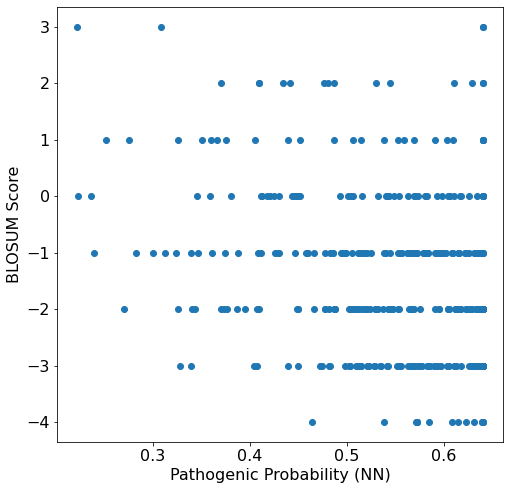

In [12]:
# Format pathogenic predictions and BLOSUM62 scores
path_preds = [nn_all_subs[i][0][1] for i in range(len(nn_all_subs))]
blosum_preds = [blosum.iloc[aa_blosum_ind[possible_pairs[i][1]]][possible_pairs[i][0]] for i in range(len(possible_pairs))]

# Plot!
plt.figure(figsize=(8,8))
plt.xlabel('Pathogenic Probability (NN)',fontsize=16)
plt.ylabel('BLOSUM Score',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(path_preds,blosum_preds,'o')
print('Pearson R: {}'.format(scipy.stats.pearsonr(path_preds,blosum_preds)))
print('Spearman R: {}'.format(scipy.stats.spearmanr(path_preds,blosum_preds)))